# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=220a37b8829d5ac97e3d3d335bc93abe7f3621c8c4e506bbe745a44bbcc9eb1e
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c144bf1a1b9935bea4d2d9c32a715f1a1c88942805adb8f32dbfd64042293314
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 17.61 MiB/s, done.
Resolving deltas: 100% (3/3), done.


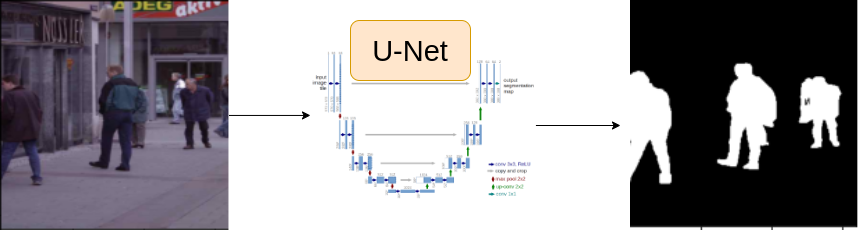

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "/content/"

DEVICE = "cuda"
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

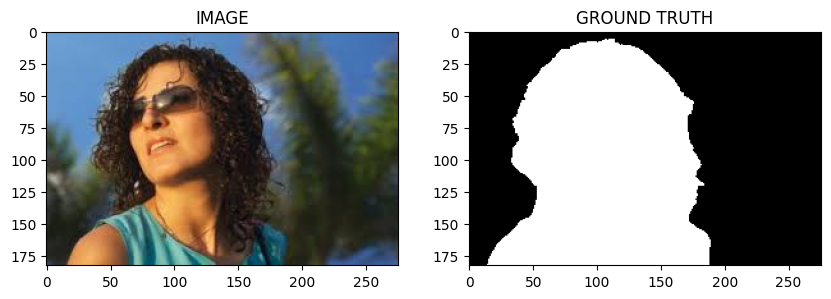

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap='gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
    ], is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE)
    ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)  # to add the channel dimension

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data["image"]
            mask = data["mask"]

        # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(float)
        mask = np.transpose(mask, (2, 0, 1)).astype(float)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


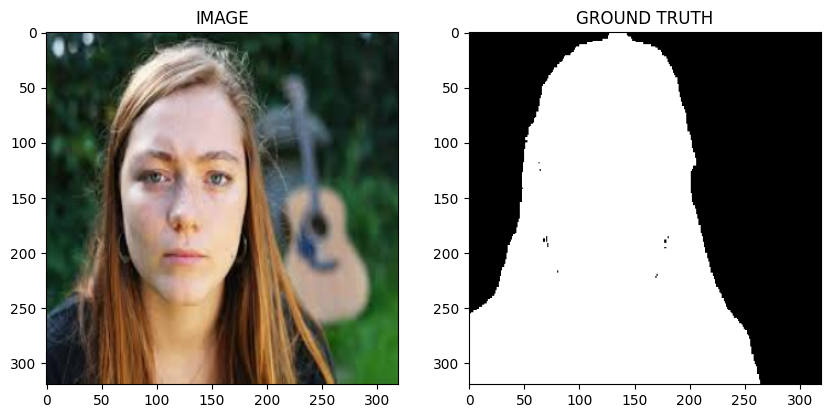

In [ ]:
idx = 0

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total number of batches in trainloader: {len(trainloader)}")
print(f"Total number of batches in validloader: {len(validloader)}")

Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [ ]:
for image, mask in trainloader:
    break

print(f"Shape of one image batch: {image.shape}")
print(f"Shape of one mask batch: {mask.shape}")

Shape of one image batch: torch.Size([16, 3, 320, 320])
Shape of one mask batch: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arch = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )

    def forward(self, images, masks=None):
        logits = self.arch(images)

        if masks is not None:
            loss1 = DiceLoss(mode="binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)

            return logits, loss1 + loss2

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arch): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
          

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for image, mask in tqdm(data_loader):

        image = image.to(DEVICE)
        mask = mask.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(image, mask)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for image, mask in tqdm(data_loader):

            image = image.to(DEVICE)
            mask = mask.to(DEVICE)

            logits, loss = model(image, mask)

            total_loss += loss.item()

        return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        print("Model saved")
        best_valid_loss = valid_loss

    print(f"Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.62it/s]


Model saved
Epoch: 1 Train_loss: 0.7667098462581634 Valid_loss: 1.2282842695713043


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Model saved
Epoch: 2 Train_loss: 0.36042695939540864 Valid_loss: 0.7984330505132675


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Model saved
Epoch: 3 Train_loss: 0.40635013083616894 Valid_loss: 0.5286528393626213


100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


Model saved
Epoch: 4 Train_loss: 0.3185189714034398 Valid_loss: 0.27380793541669846


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Model saved
Epoch: 5 Train_loss: 0.22870520850022633 Valid_loss: 0.2693093493580818


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Model saved
Epoch: 6 Train_loss: 0.188442533214887 Valid_loss: 0.2293391078710556


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Epoch: 7 Train_loss: 0.17608160972595216 Valid_loss: 0.24300656095147133


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


Epoch: 8 Train_loss: 0.14872907499472302 Valid_loss: 0.25303272902965546


100%|██████████| 4/4 [00:00<00:00,  4.27it/s]


Epoch: 9 Train_loss: 0.21346077273289363 Valid_loss: 0.2832784727215767


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch: 10 Train_loss: 0.20521050294240314 Valid_loss: 0.277299951761961


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch: 11 Train_loss: 0.22903791666030884 Valid_loss: 0.2423410266637802


100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


Model saved
Epoch: 12 Train_loss: 0.17108883808056513 Valid_loss: 0.1949438527226448


100%|██████████| 4/4 [00:00<00:00,  4.06it/s]


Epoch: 13 Train_loss: 0.16072634110848108 Valid_loss: 0.22417853586375713


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


Epoch: 14 Train_loss: 0.14964251816272736 Valid_loss: 0.2627669535577297


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch: 15 Train_loss: 0.172297299404939 Valid_loss: 0.2272065468132496


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch: 16 Train_loss: 0.14651171664396923 Valid_loss: 0.21974020451307297


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch: 17 Train_loss: 0.1376302386323611 Valid_loss: 0.20967470109462738


100%|██████████| 4/4 [00:01<00:00,  3.81it/s]


Epoch: 18 Train_loss: 0.14654245773951213 Valid_loss: 0.22149906307458878


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Model saved
Epoch: 19 Train_loss: 0.13003404339154562 Valid_loss: 0.18657589703798294


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


Model saved
Epoch: 20 Train_loss: 0.10909540553887685 Valid_loss: 0.16386980190873146


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Model saved
Epoch: 21 Train_loss: 0.09843538502852121 Valid_loss: 0.16204813867807388


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Epoch: 22 Train_loss: 0.09848566402991613 Valid_loss: 0.1730416603386402


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 23 Train_loss: 0.09168430815140406 Valid_loss: 0.1628554593771696


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Model saved
Epoch: 24 Train_loss: 0.08622466673453649 Valid_loss: 0.16195156052708626


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

Epoch: 25 Train_loss: 0.09923025866349539 Valid_loss: 0.23795083537697792


# Task 9 : Inference

In [ ]:
idx = 1

# using validation set as test set

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  # (C, H, W) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)  # need to apply sigmoid (for binary classes) because logits are in raw form
pred_mask = (pred_mask > 0.5) * 1.0

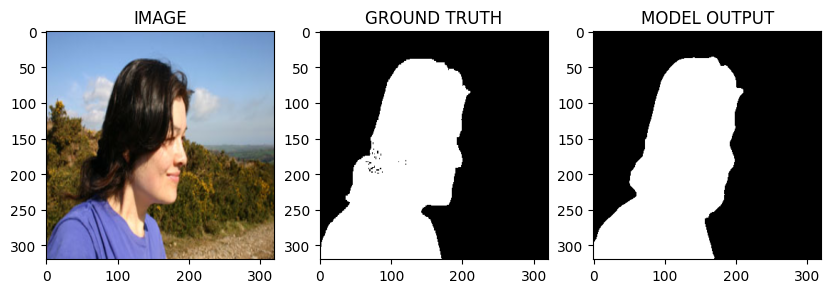

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

Coursera Guided Project By: **Parth Dhameliya**